# Machine learning project: Bank churn rate prediction 

In [261]:
#importamos las librerías necesarias
import pandas as pd
import yaml
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import chi2_contingency

from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

## Data import and cleaning

In [2]:
#importamos el dataset desde el archivo yaml
with open ('../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [3]:
#leemos el dataset
df = pd.read_csv(config['data']['df'])

In [4]:
#vemos columnas y primeras filas
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
#comprobamos el tamaño del dataset
df.shape

(10000, 14)

In [6]:
#vemos el tipo de datos de cada columna
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [7]:
#comprobamos si hay valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [8]:
#volvemos a comprobar si  hay valores nulos
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [9]:
#comprobamos si hay duplicados en todo el dataframe
df.duplicated().sum()

0

In [10]:
#no hay duplicados por CustomerId
df['CustomerId'].duplicated().sum()

0

In [11]:
#eliminamos las columnas RowNumber y Surname del dataframe
columns_to_drop = ['RowNumber', 'Surname']
df = df.drop(columns=columns_to_drop)

In [12]:
#comprobamos cuántos valores únicos hay en Gender
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

In [13]:
#comprobamos cuántos valores únicos hay en Geography
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [14]:
#agrupamos la edad en grupos hasta 30 adultos jóvenes, hasta 55 adultos de mediana edad y a partir de 55 adultos mayores
bins = [18, 30, 55, df['Age'].max()]
labels = ['Young adults', 'Middle-aged adults', 'Older adults']
df['Age_grouped'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)

In [15]:
#agrupamos el Balance en grupos de cero, bajo, medio, medio alto y alto
bins = [0, 1, 50000, 100000, 150000, df['Balance'].max()]
labels = ['Zero', 'Low', 'Medium', 'Medium high', 'High']
df['Balance_grouped'] = pd.cut(df['Balance'], bins=bins, labels=labels, include_lowest=True)

In [16]:
#agrupamos el CreditScore en alto, medio y bajo riesgo
bins = [300, 620, 700, df['CreditScore'].max()]
labels = ['High risk', 'Medium risk', 'Low risk']
df['CreditScore_grouped'] = pd.cut(df['CreditScore'], bins=bins, labels=labels, include_lowest=True)

In [17]:
#agrupamos el EstimatedSalary en alto, medio y bajo
bins = [0, 50000, 100000, df['EstimatedSalary'].max()]
labels = ['Low', 'Medium', 'High']
df['EstimatedSalary_grouped'] = pd.cut(df['EstimatedSalary'], bins=bins, labels=labels, include_lowest=True)

In [18]:
#convertimos la columna Exited a tipo objeto para el análisis EDA
df['Exited'] = df['Exited'].map({0: 'No', 1: 'Yes'})

## EDA

In [19]:
#calculamos el porcentaje de clientes que siguen siéndolo y los que no
Exited_percent = (df['Exited'].value_counts(normalize=True) * 100).reset_index()

In [20]:
#creamos el gráfico circular para ver la distribución de clientes que han dejado de serlo y los que no
fig = px.pie(Exited_percent, values='proportion', names='Exited', title='Distribution of exited customers')
fig.show()

C:\Users\perez\AppData\Local\Temp\ipykernel_6364\3779618903.py:11: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


c:\Users\perez\anaconda3\envs\bank_churn_proyect\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\perez\AppData\Local\Temp\ipykernel_6364\3779618903.py:11: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


c:\Users\perez\anaconda3\envs\bank_churn_proyect\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\perez\AppData\Local\Temp\ipykernel_6364\3779618903.py:11: FutureW

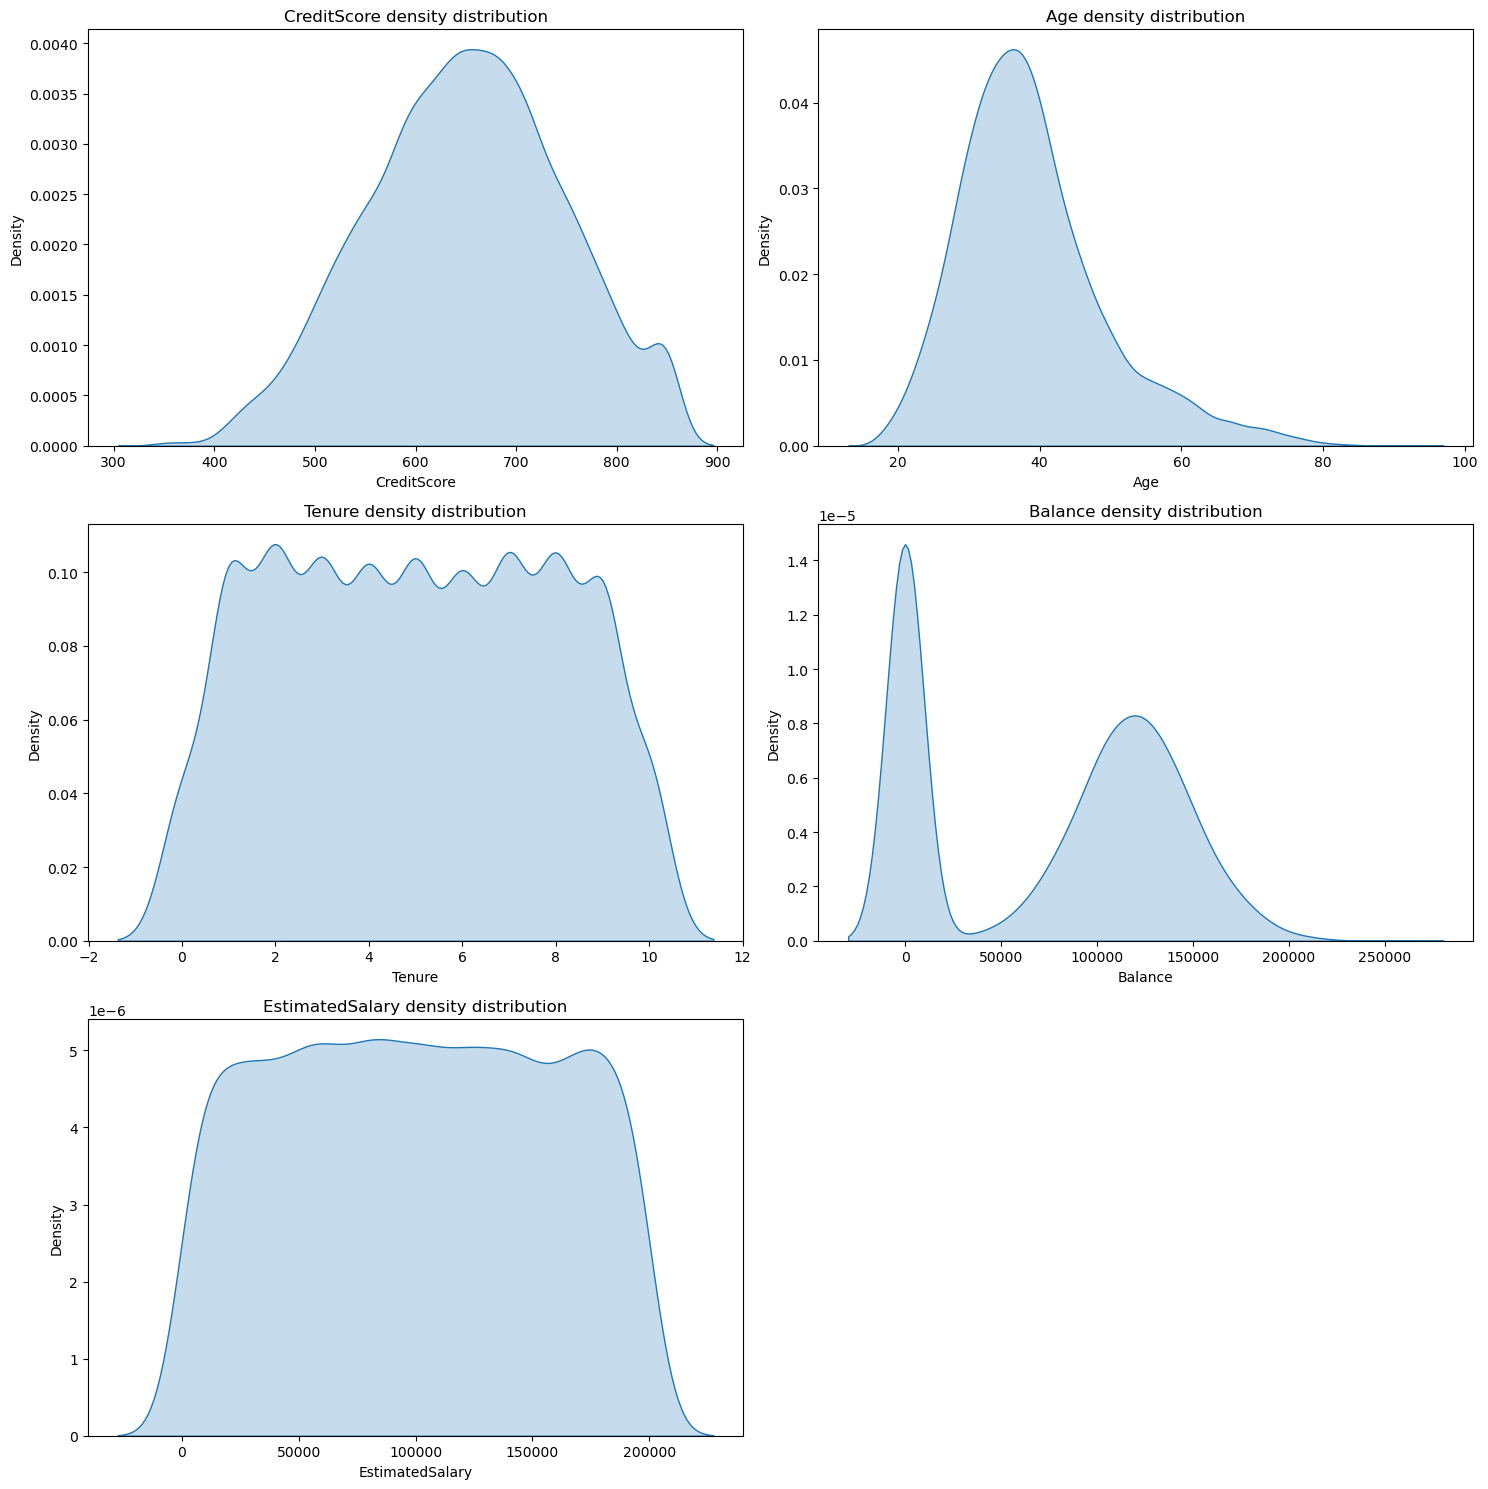

In [21]:
#comprobamos la densidad de todas las variables numéricas

numeric_var = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

#creamos una figura con un arreglo de 3 filas y 2 columnas de subgráficos
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

#iteramos sobre las variables y los ejes correspondientes
for i, var in enumerate(numeric_var):
    row, col = divmod(i, 2)
    sns.kdeplot(df[var], shade=True, ax=axes[row, col])
    axes[row, col].set_title(f'{var} density distribution')
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Density')

#ocultamos el último subgráfico vacío
axes[2, 1].axis('off')

#ajustamos el espacio entre los subgráficos
plt.tight_layout()

#mostramos la figura con todos los subgráficos
plt.show()

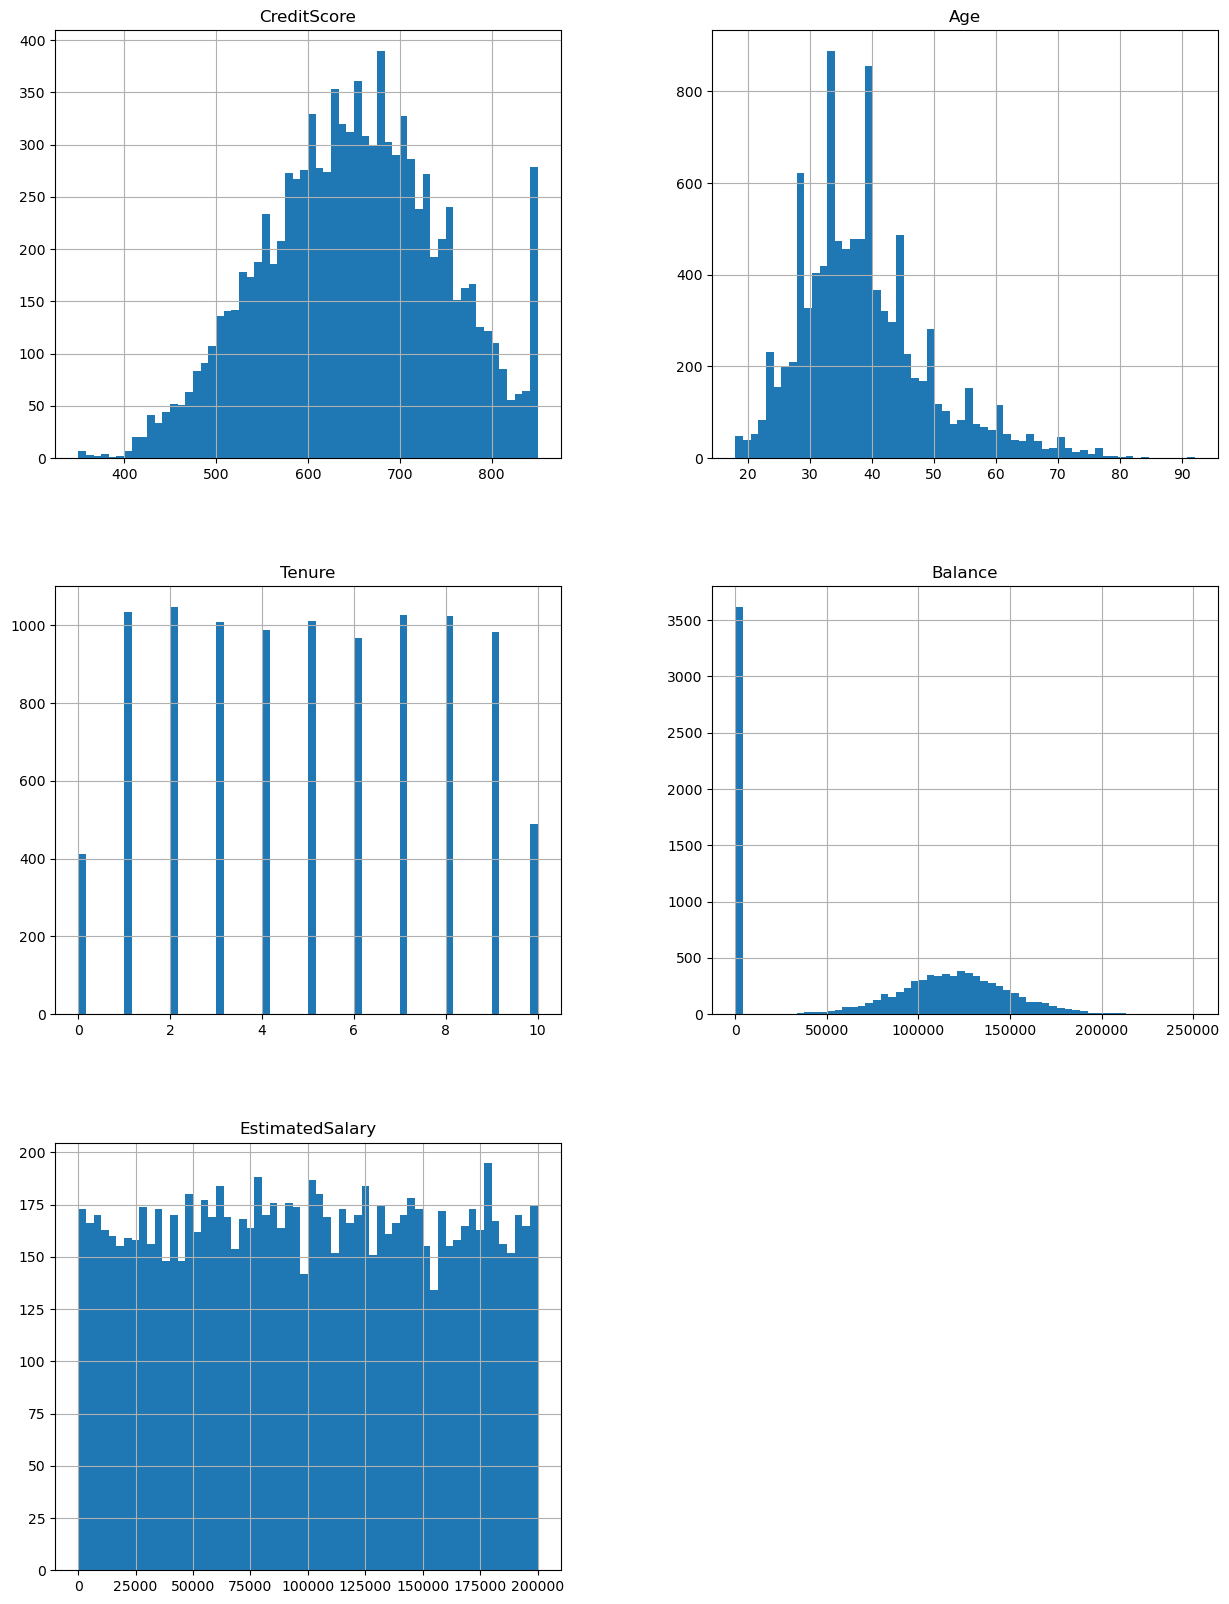

In [22]:
#comprobamos la distribución de todas las variables numéricas
numeric_var = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Exited']

ax = df[numeric_var].hist(figsize=(15, 20), bins=60, xlabelsize=10, ylabelsize=10)
for axis in ax.flatten():
    axis.ticklabel_format(style='plain', axis='x')

plt.show()

In [23]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000


In [24]:
#agrupamos los datos por Género y Exited y contamos la cantidad de clientes en cada grupo
Gender_df = df.groupby(['Gender', 'Exited'])['CustomerId'].count().reset_index()

In [25]:
#creamos un gráfico para ver la distribución de género entre los clientes que se fueron
fig = px.bar(Gender_df, x='Gender', y='CustomerId', color='Exited', title='Gender distribution among exited customers')
fig.show()

In [26]:
#agrupamos los datos por Geography y Exited y contamos la cantidad de clientes en cada grupo
Age_df = df.groupby(['Age', 'Exited'])['CustomerId'].count().reset_index()

In [27]:
#creamos un gráfico para ver la relación entre la edad y los clientes que se fueron
fig = px.scatter(Age_df, x='Age', y='CustomerId', color='Exited', title='Age distribution among exited customers')
fig.show()

In [28]:
#agrupamos los datos por Geography y Exited y contamos la cantidad de clientes en cada grupo
Geography_df = df.groupby(['Geography', 'Exited'])['CustomerId'].count().reset_index()

In [29]:
#creamos un gráfico para ver la distribución de geografía entre los clientes que se fueron
fig = px.bar(Geography_df, x='Geography', y='CustomerId', color='Exited', title='Geographic distribution among exited customers')
fig.show()

In [30]:
#agrupamos los datos por Balance y Exited y contamos la cantidad de clientes en cada grupo
Balance_df = df.groupby(['Balance_grouped', 'Exited'])['CustomerId'].count().reset_index()

C:\Users\perez\AppData\Local\Temp\ipykernel_6364\2551477476.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [31]:
#creamos un gráfico para ver la distribución de geografía entre los clientes que se fueron
fig = px.bar(Balance_df.rename(columns={'CustomerId':'Num_clients', 'Balance_grouped':'Balance'}), x='Balance', y='Num_clients', color='Exited', title='Balance distribution among exited customers',\
             hover_data=['Balance'])
fig.show()

In [32]:
#agrupamos los datos por Balance y Exited y contamos la cantidad de clientes en cada grupo
CreditScore_df = df.groupby(['CreditScore_grouped', 'Exited'])['CustomerId'].count().reset_index()

C:\Users\perez\AppData\Local\Temp\ipykernel_6364\2828156295.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [33]:
#creamos un gráfico para ver la distribución de geografía entre los clientes que se fueron
fig = px.bar(CreditScore_df, x='CreditScore_grouped', y='CustomerId', color='Exited', title='CreditScore distribution among exited customers')
fig.show()

In [34]:
#agrupamos los datos por Balance y Exited y contamos la cantidad de clientes en cada grupo
Tenure_df = df.groupby(['Tenure', 'Exited'])['CustomerId'].count().reset_index()

In [35]:
#creamos el gráfico
fig = px.bar(Tenure_df, x="Tenure", y="CustomerId", color="Exited", barmode='group')

#modificamos el título y etiquetas del gráfico
fig.update_layout(title="Tenure distribution among exited customers", xaxis_title='Tenure', yaxis_title='NumClients')

#mostramos el gráfico
fig.show()

In [36]:
#agrupamos los datos por EstimatedSalary y Exited y contamos la cantidad de clientes en cada grupo
EstimatedSalary_df = df.groupby(['EstimatedSalary_grouped', 'Exited'])['CustomerId'].count().reset_index()

C:\Users\perez\AppData\Local\Temp\ipykernel_6364\1229949560.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [37]:
#creamos un gráfico para ver la distribución de EstimatedSalary entre los clientes que se fueron
fig = px.bar(EstimatedSalary_df, x='EstimatedSalary_grouped', y='CustomerId', color='Exited', title='EstimatedSalary distribution among exited customers')
fig.show()

In [38]:
#agrupamos los datos por NumOfProducts y Exited y contamos la cantidad de clientes en cada grupo
NumOfProducts_df = df.groupby(['NumOfProducts', 'Exited'])['CustomerId'].count().reset_index()

In [39]:
#creamos el gráfico
fig = px.bar(NumOfProducts_df, x="NumOfProducts", y="CustomerId", color="Exited", barmode='group')

#modificamos el título y etiquetas del gráfico
fig.update_layout(title="NumOfProducts distribution among exited customers", xaxis_title='NumOfProducts', yaxis_title='NumClients')

#mostramos el gráfico
fig.show()

In [40]:
#agrupamos los datos por HasCrCard y Exited y contamos la cantidad de clientes en cada grupo
HasCrCard_df = df.groupby(['HasCrCard', 'Exited'])['CustomerId'].count().reset_index()

In [41]:
#creamos el gráfico
fig = px.bar(HasCrCard_df, x="HasCrCard", y="CustomerId", color="Exited", barmode='group')

#modificamos el título y etiquetas del gráfico
fig.update_layout(title="HasCrCard distribution among exited customers", xaxis_title='HasCrCard', yaxis_title='NumClients')

#mostramos el gráfico
fig.show()

In [42]:
#agrupamos los datos por IsActiveMember y Exited y contamos la cantidad de clientes en cada grupo
IsActiveMember_df = df.groupby(['IsActiveMember', 'Exited'])['CustomerId'].count().reset_index()

In [43]:
#creamos el gráfico
fig = px.bar(IsActiveMember_df, x="IsActiveMember", y="CustomerId", color="Exited", barmode='group')

#modificamos el título y etiquetas del gráfico
fig.update_layout(title="IsActiveMember distribution among exited customers", xaxis_title='IsActiveMember', yaxis_title='NumClients')

#mostramos el gráfico
fig.show()

### EDA Conclusion

#### Univariable Analysis

Total histórico de clientes 10.000.

El 79.6% continúa siéndolo, mientras que el 20.4% ha dejado de serlo.

La mayor parte de los clientes tiene entre 30 y 50 años. Parece que hay outliers a partir de los 80 años.

Los años de permanencia son muy variados, entre 0 y 10 años.

La mayor parte de los clientes tiene un CreditScore de entre 600 y 700, lo cual entra dentro de la normalidad del sector, aunque la distribución presenta un pico en los que tienen más de 800.

Hay muchos clientes con balance 0 en la cuenta y luego la mayoría están entre 100.000 y 150.000 dólares.

El salario estimado es muy variado y se encuentra entre 0 y 200.000 dólares.

#### Bivariable Analysis

La mayor parte de los clientes son hombres y parece que las mujeres tienen algo más de tendencia a dejar de ser clientes que los hombres.

La mayor parte de los clientes que siguen siéndolo tienen entre 30 y 40 años, los que se van están mayoritariamente entre los 35 y los 55 aproximadamente. Mientras que los que se quedan entre 30 y 40.

La mayor parte de los clientes son de Francia. De Alemania y España son un porcentaje bastante parejo. Parece que del país del que más clientes dejan de serlo es Alemania y del que menos España.

Confirmamos que hay un porcentaje bastante amplio de clientes con saldo 0, seguido de Medium high (de 100.000 a 150.000 dólares).

La mayor parte de los clientes son de alto riesgo (CreditScore) independientemente de si siguen siendo clientes o no.

La mayor parte de los clientes llevan siéndolo entre 1 y 9 años, aunque hay bastantes que tan solo llevan uno y los que más llevan un total de 10 años. No parece que haya relación entre este aspecto y si continúan o no en el banco como clientes.

La mayor parte de los clientes tiene un salario estimado alto (+100.000 dólares) y también son estos los que más dejan de ser clientes, aunque en proporción similar a la mayor cantidad de clientes con sueldo alto.

La mayor parte de los clientes tiene 1 o 2 productos contratados y los que tan solo tienen 1 producto son más propensos a dejar de ser clientes que el resto de clientes, aquí de una manera más clara.

La mayor parte de los clientes tiene tarjeta de crédito, haya dejado de ser cliente o no.

La mayor parte de los clientes es activa y en el gráfico podemos observar que hay una tendencia a que los que menos activos tiendan a dejar de ser clientes con mayor facilidad.

In [44]:
#devolvemos la columna Exited a tipo numérico para la predicción logarítmica
df['Exited'] = df['Exited'].map({'No': 0, 'Yes': 1})

c:\Users\perez\anaconda3\envs\bank_churn_proyect\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\perez\anaconda3\envs\bank_churn_proyect\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\perez\anaconda3\envs\bank_churn_proyect\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\perez\anaconda3\envs\bank_churn_proyect\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future ve

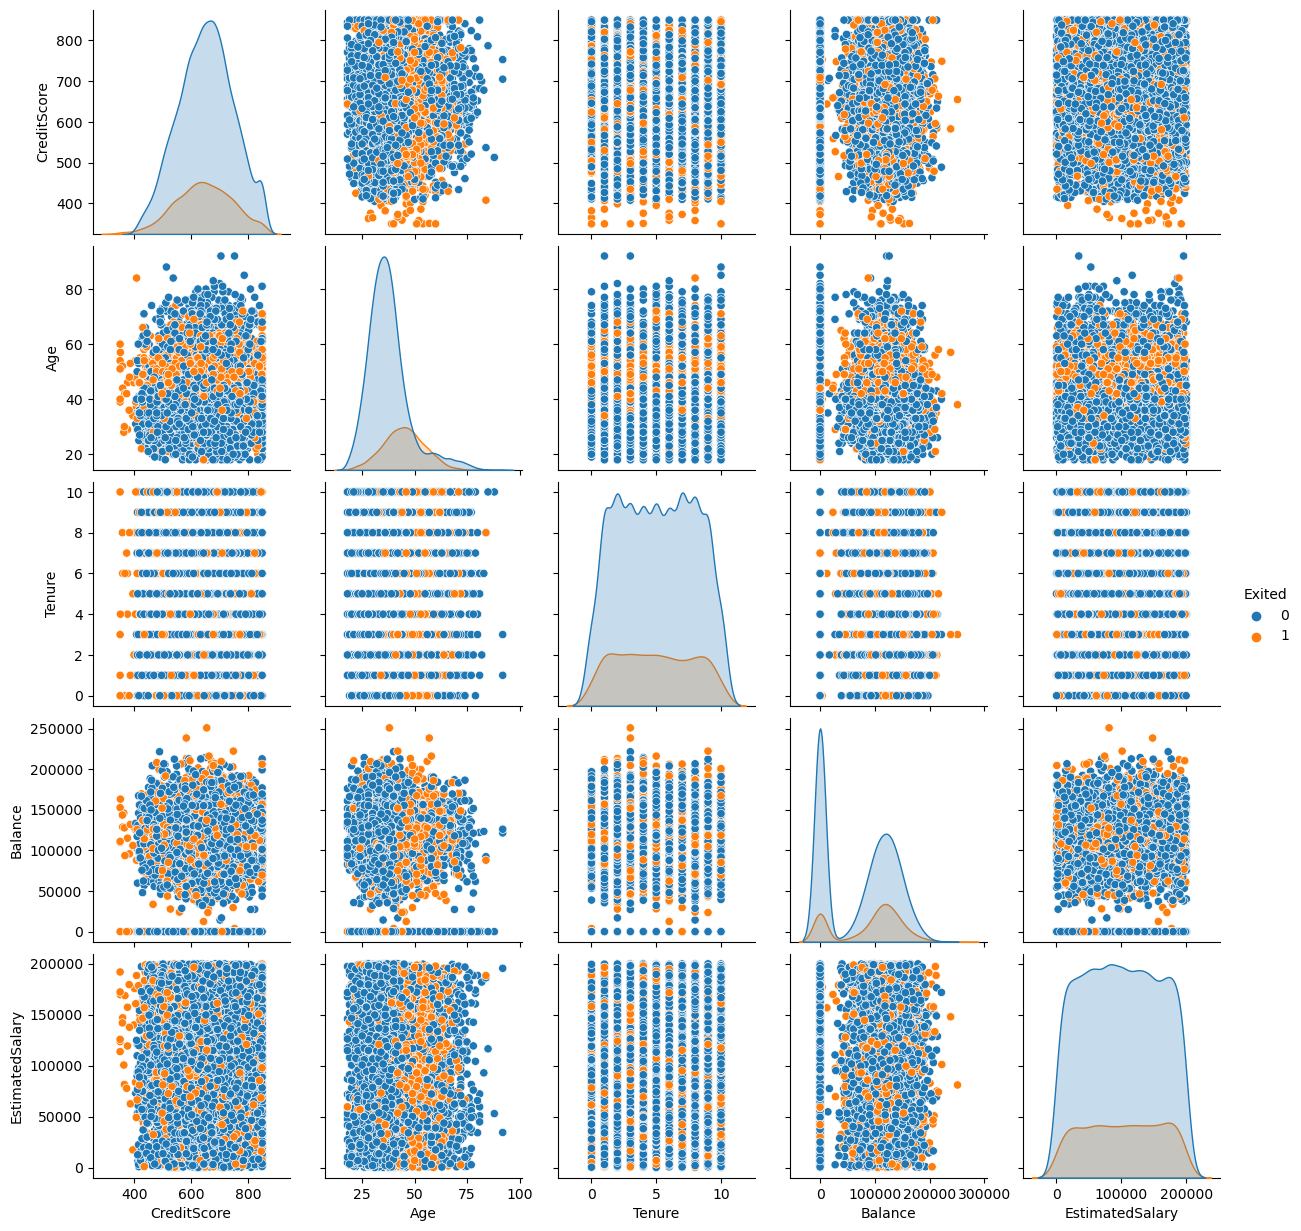

In [45]:
#creamos un pairplot para comprobar la relación entre las variables numéricas
sns.pairplot(df[numeric_var], hue='Exited')

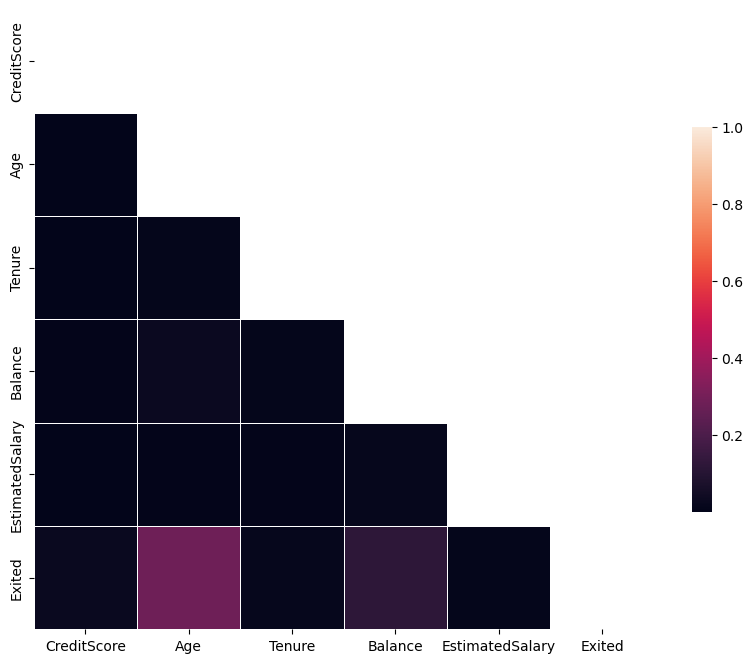

In [46]:
#creamos un gráfico de correlación de las variables numéricas
corr=np.abs(df[numeric_var].corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=corr)

plt.show()

In [47]:
#calculamos el chi cuadrado para cuantificar la relación entre las variables categóricas
categoric_var = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']

results = {}
for col1 in df[categoric_var]:
    for col2 in df[categoric_var]:
        if col1 != col2:
            contingency_table = pd.crosstab(df[categoric_var][col1], df[categoric_var][col2])
            chi2, p, dof, ex = chi2_contingency(contingency_table)
            results[(col1, col2)] = {'chi2': chi2, 'p': p}

In [48]:
#organizamos los datos en una matriz cuadrada
chi_squared_matrix = pd.DataFrame.from_dict(results, orient='index').reset_index()

c:\Users\perez\anaconda3\envs\bank_churn_proyect\Lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



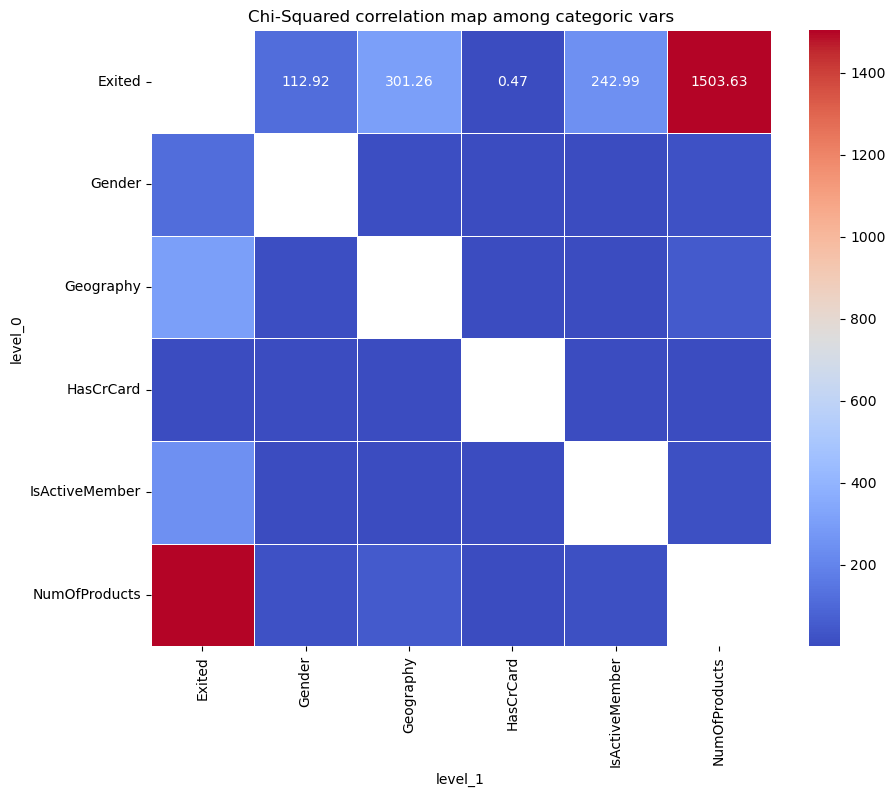

In [49]:
#creamos un mapa de calor con seaborn
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(chi_squared_matrix.pivot(index='level_0', columns='level_1', values='chi2'),
                      annot=True,
                      cmap='coolwarm',
                      linewidths=0.5,
                      fmt=".2f")
heatmap.set_title('Chi-Squared correlation map among categoric vars')
plt.show()

### EDA Conclusion for Logarithmic Prediction

Vemos que hay una correlación importante entre Exited, la variable a predecir, y NumOfProducts, variable categórica.

Además, el resto de variables categóricas no están correlacionadas entre sí.

Con Age y Balance, variables numéricas, también hay correlación con Exited, pero en mucha menor medida.

El resto de variables numéricas tampoco están relacionadas entre sí.

## Prediction model setup

In [50]:
#df toda la data
#df['Exited'] variable a predecir
#df['NumOfProducts'] variable categórica correlacionada fuertemente
#df['Age'], df['Balance'] variables numéricas correlacionadas de forma débil

In [51]:
#eliminamos la columna CustomerId, ya que no la vamos a usar para la definición del algoritmo de predicción
columns_to_drop = ['CustomerId']
df = df.drop(columns=columns_to_drop)

In [52]:
#creamos una nueva columna con el promedio del número de productos por geografía y la desviación estandar
#para ello, primero creamos un dataframe y hacemos un groupby por número de productos y la geografía
NumOfProducts_per_geography_sum_df = df[['Geography', 'NumOfProducts']].groupby('Geography').mean().reset_index()
NumOfProducts_per_geography_std_df = df[['Geography', 'NumOfProducts']].groupby('Geography').std().reset_index()

In [53]:
#hacemos dos merge left para añadir los nuevos dataframes al original
df = pd.merge(df, NumOfProducts_per_geography_sum_df, on='Geography', how='left')
df = pd.merge(df, NumOfProducts_per_geography_std_df, on='Geography', how='left')

In [54]:
#cambiamos el nombre de las columnas
df = df.rename(columns={'NumOfProducts_y': 'Avg_NumOfProducts_per_Geography', 'NumOfProducts' : 'Std_NumOfProducts_per_Geography', 'NumOfProducts_x' : 'NumOfProducts'})

In [55]:
#convertimos las variables categóricas en booleanas
df_dummies = pd.get_dummies(df, columns = ['Geography', 'Gender'])

In [56]:
#creamos una nueva columna con el promedio por valor agrupado de Age
#para ello, primero creamos un dataframe y hacemos un groupby por el valor agrupado y la media de Age
age_df = df_dummies.groupby('Age_grouped').agg({'Age':'mean'}).reset_index()

C:\Users\perez\AppData\Local\Temp\ipykernel_6364\3520098334.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [57]:
#hacemos un merge left para unir el nuevo dataframe al original
df_dummies = pd.merge(df_dummies, age_df, on='Age_grouped', how='left')

In [58]:
#creamos una nueva columna con el promedio por valor agrupado de Balance
#para ello, primero creamos un dataframe y hacemos un groupby por el valor agrupado y la media de Balance
balance_df = df_dummies.groupby('Balance_grouped').agg({'Balance':'mean'}).reset_index()

C:\Users\perez\AppData\Local\Temp\ipykernel_6364\399780028.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [59]:
#hacemos un merge left para unir el nuevo dataframe al original
df_dummies = pd.merge(df_dummies, balance_df, on='Balance_grouped', how='left')

In [60]:
#creamos una nueva columna con el promedio por valor agrupado de creditscore
#para ello, primero creamos un dataframe y hacemos un groupby por el valor agrupado y la media de creditscore
creditscore_df = df_dummies.groupby('CreditScore_grouped').agg({'CreditScore':'mean'}).reset_index()

C:\Users\perez\AppData\Local\Temp\ipykernel_6364\4244589675.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [61]:
#hacemos un merge left para unir el nuevo dataframe al original
df_dummies = pd.merge(df_dummies, creditscore_df, on='CreditScore_grouped', how='left')

In [62]:
#creamos una nueva columna con el promedio por valor agrupado de EstimatedSalary
#para ello, primero creamos un dataframe y hacemos un groupby por el valor agrupado y la media de EstimatedSalary
estimatedsalary_df = df_dummies.groupby('EstimatedSalary_grouped').agg({'EstimatedSalary':'mean'}).reset_index()

C:\Users\perez\AppData\Local\Temp\ipykernel_6364\1677954871.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [63]:
#hacemos un merge left para unir el nuevo dataframe al original
df_dummies = pd.merge(df_dummies, estimatedsalary_df, on='EstimatedSalary_grouped', how='left')

In [64]:
#cambiamos el nombre de las columnas
df_dummies = df_dummies.rename(columns={'CreditScore_x': 'CreditScore', 'CreditScore_y' : 'Avg_grouped_CreditScore', 'Age_x' : 'Age', 'Age_y' : 'Avg_grouped_Age', 'Balance_x' : 'Balance', 'Balance_y' : 'Avg_grouped_Balance', 'EstimatedSalary_x' : 'EstimatedSalary',\
                    'EstimatedSalary_y' : 'Avg_grouped_EstimatedSalary'})

In [65]:
#eliminamos la columna Age_grouped, Balance_grouped, CreditScore_grouped, EstimatedSalary_grouped ya que no la vamos a usar para la definición del algoritmo de predicción y las hemos transformado en numéricas
columns_to_drop = ['Age_grouped', 'Balance_grouped', 'CreditScore_grouped', 'EstimatedSalary_grouped']
df_dummies = df_dummies.drop(columns=columns_to_drop)

In [66]:
#calculamos el índice de correlación entre todas las variables de df_dummies para seleccionar las variables que emplearemos en el algoritmo
corr = df_dummies.corr()

In [67]:
#creamos el mapa de calor para ver la correlación entre variables en df_dummies
#creamos una máscara para la parte superior del triángulo
mask = np.triu(np.ones_like(corr, dtype=bool))

#aplicamos la máscara a la matriz de correlación
corr_masked = corr.mask(mask)

#convertimos la matriz de correlación en un DataFrame de larga distancia
corr_long = corr.reset_index().melt(id_vars='index')
corr_long.columns = ['Variable1', 'Variable2', 'Correlation']

#creamos el gráfico de calor
fig = px.imshow(corr, 
                labels=dict(x="Variables", y="Variables", color="Correlation"),
                x=corr.columns,
                y=corr.index,
                zmin=-1, zmax=1,
                color_continuous_scale=px.colors.diverging.Tealrose,
                aspect="equal"  #hace el gráfico cuadrado
               )

#agregamos anotaciones
for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        if not mask[i, j]:
            fig.add_annotation(dict(
                x=corr.columns[j],
                y=corr.index[i],
                text=str(round(corr.values[i, j], 2)),
                showarrow=False,
                font=dict(size=10)
            ))

fig.update_layout(
    title="Heatmap of Correlation Matrix",
    xaxis_nticks=len(corr.columns),
    yaxis_nticks=len(corr.index),
    autosize=False,
    width=1600,
    height=1000,
)

fig.show()

## Prediction model

In [221]:
#seleccionamos las variables que emplearemos en el algoritmo y definimos nuestro target en 'Exited'
features = df_dummies[['Age', 'Balance', 'IsActiveMember', 'NumOfProducts', 'Tenure', 'Gender_Female', 'Geography_France', 'Geography_Spain', 'Geography_Germany']]
target = df_dummies['Exited']

In [222]:
#dividimos los datos en conjuntos de entrenamiento y prueba, donde el 20% de los datos se utiliza para la prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

In [223]:
#predecimos una clasificación al ser nuestra variable de predicción booleana

#### KNN

In [224]:
#usamos el modelo knn
knn = KNeighborsClassifier(n_neighbors=20)

In [225]:
#entrenamos el modelo
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [226]:
#realizamos predicciones
y_predict = knn.predict(X_test)

In [227]:
knn_precision = precision_score(y_test, y_predict, average='macro')
knn_recall = recall_score(y_test, y_predict, average='macro') 
knn_f1 = f1_score(y_test, y_predict, average='macro')

knn_precision, knn_recall, knn_f1

(0.6413996358243698, 0.5116606679825071, 0.4731979737585119)

#### Normalized model

In [228]:
#utilizamos el MinMaxScaler para normalizar nuestros datos y que estén en el rango [0, 1]
normalizer = MinMaxScaler()

In [229]:
#ajustamos el normalizador con los datos de entrenamiento
normalizer.fit(X_train)

MinMaxScaler()

In [230]:
#transformamos los datos de entrenamiento utilizando el normalizador
X_train_norm = normalizer.transform(X_train)

#transformamos los datos de prueba utilizando el normalizador
X_test_norm = normalizer.transform(X_test)

In [231]:
#convertimos los datos en dos nuevos dataframes
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)

In [232]:
#ya que queremos predecir una variable booleana utilizamos un algoritmo de clasificación para el modelo knn
knn_norm = KNeighborsClassifier(n_neighbors=35)

In [233]:
#entrenamos el modelo KNN con los datos normalizados
knn_norm.fit(X_train_norm, y_train)

KNeighborsClassifier(n_neighbors=35)

In [234]:
#realizamos predicciones sobre los datos normalizados
y_predict_norm = knn_norm.predict(X_test_norm)

In [235]:
#calculamos el mse, mae y r2 para evaluar el modelo normalizado
precision_norm = precision_score(y_test, y_predict_norm, average='macro')
recall_norm = recall_score(y_test, y_predict_norm, average='macro') 
f1_norm = f1_score(y_test, y_predict_norm, average='macro')

precision_norm, recall_norm, f1_norm

(0.7653714970501475, 0.6426061380084369, 0.6702092104168604)

#### Standardized model

In [236]:
#utilizamos el StandardScaler para estandarizar nuestros datos
scaler = StandardScaler()


In [237]:
#transformamos los datos de entrenamiento utilizando el estandarizador
X_train_standardized = scaler.fit_transform(X_train)

#transformamos los datos de test utilizando el estandarizador
X_test_standardized = scaler.transform(X_test)

In [238]:
#ya que queremos predecir una variable booleana utilizamos un algoritmo de clasificación para el modelo knn
knn_standardized = KNeighborsClassifier(n_neighbors=32)

In [239]:
#entrenamos el modelo
knn_standardized.fit(X_train_standardized, y_train)

KNeighborsClassifier(n_neighbors=32)

In [240]:
#realizamos predicciones sobre los datos estandarizados
y_predict_standardized = knn_standardized.predict(X_test_standardized)

In [241]:
#calculamos el mse, mae y r2 para evaluar el modelo normalizado
precision_standardized  = precision_score(y_test, y_predict_standardized, average='macro')
recall_standardized  = recall_score(y_test, y_predict_standardized, average='macro') 
f1_standardized  = f1_score(y_test, y_predict_standardized, average='macro')

precision_standardized, recall_standardized, f1_standardized

(0.8049491383421952, 0.6870699330469445, 0.7204403442361599)

In [258]:
#la distribución de la variable que queremos predecir no es balanceada.
fig = px.pie(Exited_percent, values='proportion', names='Exited', title='Distribution of exited customers')
fig.show()

In [262]:
#creamos un objeto SMOTE para balancear la data
sm = SMOTE(random_state = 1,sampling_strategy=1.0)

In [263]:
X_train_sm,y_train_sm = sm.fit_resample(X_train_norm,y_train)

#### Random forest

In [264]:
#iniciamos un random forest con los datos normalizados, ya que era el modelo que mejor resultados ofrecía
forest = RandomForestClassifier(n_estimators=50,
                             max_depth=50)

In [265]:
#entrenamos el modelo con los datos normalizados
forest.fit(X_train_sm, y_train_sm)

RandomForestClassifier(max_depth=50, n_estimators=50)

In [266]:
#evaluamos el modelo
pred = forest.predict(X_test_norm)

precision_forest  = precision_score(y_test, pred, average='macro')
recall_forest  = recall_score(y_test, pred, average='macro') 
f1_forest  = f1_score(y_test, pred, average='macro')

precision_forest, recall_forest, f1_forest

(0.7214747388373055, 0.7461821277913232, 0.732076582175626)

#### Bagging model

In [270]:
#probamos el modelo bagging
bagging= BaggingClassifier(DecisionTreeClassifier(max_depth=20),
                               n_estimators=45,
                               max_samples = 1000)

In [271]:
#entrenamos el modelo
bagging.fit(X_train_sm, y_train_sm)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                  max_samples=1000, n_estimators=45)

In [272]:
#evaluamos el resultado
pred = bagging.predict(X_test_norm)

precision_bagging  = precision_score(y_test, pred, average='macro')
recall_bagging  = recall_score(y_test, pred, average='macro') 
f1_bagging  = f1_score(y_test, pred, average='macro')

precision_bagging, recall_bagging, f1_bagging

(0.7227385288392978, 0.7862804288091645, 0.7421257080240098)

#### Ada boost model

In [273]:
#probamos el modelo adaboost
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20),
                            n_estimators=20)

In [274]:
#entrenamos el modelo
ada.fit(X_train_sm, y_train_sm)

c:\Users\perez\anaconda3\envs\bank_churn_proyect\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=20),
                   n_estimators=20)

In [275]:
#evaluamos el resultado del modelo
pred = ada.predict(X_test_norm)

precision_ada_boost  = precision_score(y_test, pred, average='macro')
recall_ada_boost  = recall_score(y_test, pred, average='macro') 
f1_ada_boost  = f1_score(y_test, pred, average='macro')

precision_ada_boost, recall_ada_boost, f1_ada_boost

(0.698069241011984, 0.7293509810751191, 0.710361651024408)

#### Gradient boost model

In [281]:
#probamos con el modelo Gradient Boost
gb= GradientBoostingClassifier(max_depth=20,
                                   n_estimators=2000)

In [282]:
#entrenamos el modelo
gb.fit(X_train_sm, y_train_sm)

GradientBoostingClassifier(max_depth=20, n_estimators=2000)

In [283]:
pred = gb.predict(X_test_norm)

precision_gradient_boost  = precision_score(y_test, pred, average='macro')
recall_gradient_boost  = recall_score(y_test, pred, average='macro') 
f1_gradient_boost  = f1_score(y_test, pred, average='macro')

precision_gradient_boost, recall_gradient_boost, f1_gradient_boost

(0.7292533406101749, 0.7432021363055845, 0.7357024009034172)

### Algorithmic Results

In [254]:
#creamos un diccionario para almacenar los resultados de los modelos
results = {}

In [255]:
#agregamos los resultados de cada modelo
results['KNN'] = {'Precision': knn_precision, 'Recall': knn_recall, 'F1': knn_f1}
results['KNN_normalized'] = {'Precision': precision_norm, 'Recall': recall_norm, 'F1': f1_norm}
results['KNN_standardized'] = {'Precision': precision_standardized, 'Recall': recall_standardized, 'F1': f1_standardized}
results['Random_forest'] = {'Precision': precision_forest, 'Recall': recall_forest, 'F1': f1_forest}
results['Bagging'] = {'Precision': precision_bagging, 'Recall': recall_bagging, 'F1': f1_bagging}
results['Ada_boost'] = {'Precision': precision_ada_boost, 'Recall': recall_ada_boost, 'F1': f1_ada_boost}
results['Gradient_boost'] = {'Precision': precision_gradient_boost, 'Recall': recall_gradient_boost, 'F1': f1_gradient_boost}

In [256]:
#creamos un dataframe a partir del diccionario de resultados
results_df = pd.DataFrame.from_dict(results, orient='index')

In [257]:
#mostramos el dataframe con los resultados de los modelos testados
results_df

,Precision,Recall,F1
KNN,0.641400,0.511661,0.473198
KNN_normalized,0.765371,0.642606,0.670209
KNN_standardized,0.804949,0.687070,0.720440
Random_forest,0.775870,0.736495,0.752997
Bagging,0.809242,0.739433,0.765706
Ada_boost,0.723687,0.716158,0.719766
Gradient_boost,0.735087,0.731600,0.733312
